In [2]:
from pyspark.sql import SparkSession

In [3]:
from pyspark.sql.functions import isnull , when ,count,col

In [4]:
spark = SparkSession.builder.appName("Cred_crd_frud_det").getOrCreate()

In [5]:
df_card_transdata = spark.read.csv("./card_transdata.csv", inferSchema= True, header = True)

In [6]:
df_card_transdata.printSchema()

root
 |-- distance_from_home: double (nullable = true)
 |-- distance_from_last_transaction: double (nullable = true)
 |-- ratio_to_median_purchase_price: double (nullable = true)
 |-- repeat_retailer: double (nullable = true)
 |-- used_chip: double (nullable = true)
 |-- used_pin_number: double (nullable = true)
 |-- online_order: double (nullable = true)
 |-- fraud: double (nullable = true)



In [7]:
df_card_transdata.show(10)

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

In [8]:
print("0: ",df_card_transdata.filter(col('fraud')== 0).count())
print("1: ",df_card_transdata.filter(col('fraud')== 1).count())

0:  912597
1:  87403


# DATA Prepartion Und Feature Engineering

In [9]:
# see if we have missing values
from ipaddress import collapse_addresses
from pyspark.sql.functions import isnull , when ,count,col
df_card_transdata.select([count(when(isnull(c),c)).alias(c) for c in df_card_transdata.columns]).show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|                 0|                             0|                             0|              0|        0|              0|           0|    0|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+



In [10]:
import seaborn as sms

<AxesSubplot:>

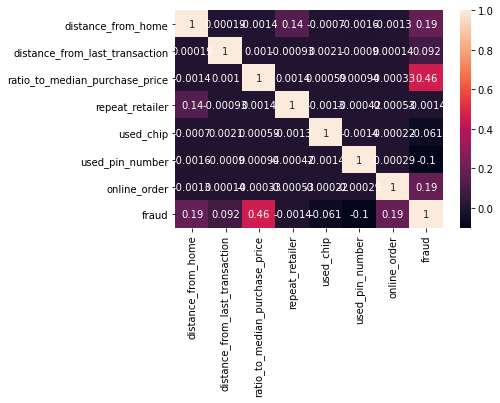

In [11]:
sms.heatmap(df_card_transdata.toPandas().corr() , annot = True)

In [12]:
from pyspark.ml.feature import VectorAssembler


In [13]:
df_card_transdata_without_lables = df_card_transdata.drop('fraud')

# Assemble All the features with VectorAssembler

In [14]:
from pyexpat import features


assembler = VectorAssembler(inputCols= df_card_transdata_without_lables.columns, outputCol="features")
transformed_data = assembler.transform(df_card_transdata)
transformed_data.select(col('features')).show()

+--------------------+
|            features|
+--------------------+
|[57.8778565838972...|
|[10.8299426992555...|
|[5.09107949061699...|
|[2.24756432829636...|
|[44.1909360026183...|
|[5.58640767418640...|
|[3.72401912471481...|
|[4.84824657228056...|
|(7,[0,1,2],[0.876...|
|[8.83904670372637...|
|[14.2635297350690...|
|[13.5923675679096...|
|[765.282559261246...|
|[2.13195566599056...|
|[13.9559723670444...|
|[179.665147685707...|
|[114.519789391612...|
|[3.58964859762134...|
|[11.0851524840576...|
|[6.19467076632605...|
+--------------------+
only showing top 20 rows



# Machine Learning Data Modal

In [15]:
(X_train, X_test) = transformed_data.randomSplit([0.7,0.3])

# Classifier

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression, RandomForestClassifier

clf_Des_tree = DecisionTreeClassifier(featuresCol='features', labelCol='fraud', maxDepth= 3, maxMemoryInMB=10000)
clf_logical_reg = LogisticRegression(featuresCol='features', labelCol='fraud')
clf_rand_frst = RandomForestClassifier(featuresCol='features', labelCol='fraud')

In [17]:
model_des_tree = clf_Des_tree.fit(X_train)

In [18]:
model_logistion_reg = clf_logical_reg.fit(X_train)

In [19]:
model_rand_frst = clf_rand_frst.fit(X_train)

In [20]:
df_card_transdata.printSchema()

root
 |-- distance_from_home: double (nullable = true)
 |-- distance_from_last_transaction: double (nullable = true)
 |-- ratio_to_median_purchase_price: double (nullable = true)
 |-- repeat_retailer: double (nullable = true)
 |-- used_chip: double (nullable = true)
 |-- used_pin_number: double (nullable = true)
 |-- online_order: double (nullable = true)
 |-- fraud: double (nullable = true)



# Predictions 

decision Tree

In [21]:
prediction_des_tree = model_des_tree.transform(X_test)

prediction_des_tree.select("fraud",'prediction').show(5)

+-----+----------+
|fraud|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Logistic Regression

In [22]:
prediction_logical_reg = model_logistion_reg.transform(X_test)

prediction_logical_reg.select("fraud",'prediction').show(5)

+-----+----------+
|fraud|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Random Forest

In [23]:
prediction_rand_frst = model_rand_frst.transform(X_test)

prediction_rand_frst.select("fraud",'prediction').show(5)

+-----+----------+
|fraud|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [24]:
print("decision Tree")
prediction_des_tree.groupBy('fraud','prediction').count().show()
print("Logistic Regression")
prediction_logical_reg.groupBy('fraud','prediction').count().show()
print("Random Forest")
prediction_rand_frst.groupBy('fraud','prediction').count().show()
# if the label is 0 and the prediction is 1 then the model has gotit wrong
# if the label is 1 and the prediction is 0 then the model has gotit wrong
# if the label is 0 and the prediction is 0 then the model has gotit right
# if the label is 1 and the prediction is 1 then the model has gotit right

decision Tree
+-----+----------+------+
|fraud|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 23072|
|  0.0|       1.0|  4379|
|  1.0|       0.0|  2934|
|  0.0|       0.0|269340|
+-----+----------+------+

Logistic Regression
+-----+----------+------+
|fraud|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 15464|
|  0.0|       1.0|  1828|
|  1.0|       0.0| 10542|
|  0.0|       0.0|271891|
+-----+----------+------+

Random Forest
+-----+----------+------+
|fraud|prediction| count|
+-----+----------+------+
|  1.0|       1.0| 22979|
|  0.0|       1.0|  1726|
|  1.0|       0.0|  3027|
|  0.0|       0.0|271993|
+-----+----------+------+



# Parameters for confusion Metrix

In [25]:
# Calculare the elements of thr confusion matrix

TN_DT = prediction_des_tree.filter('prediction = 0 AND fraud = prediction').count()
TP_DT = prediction_des_tree.filter('prediction = 1 AND fraud = prediction').count()
FN_DT = prediction_des_tree.filter('prediction = 0 AND fraud <> prediction').count()
FP_DT = prediction_des_tree.filter('prediction = 1 AND fraud <> prediction').count()

In [26]:
TN_LR= prediction_logical_reg.filter('prediction = 0 AND fraud = prediction').count()
TP_LR= prediction_logical_reg.filter('prediction = 1 AND fraud = prediction').count()
FN_LR= prediction_logical_reg.filter('prediction = 0 AND fraud <> prediction').count()
FP_LR= prediction_logical_reg.filter('prediction = 1 AND fraud <> prediction').count()

In [27]:
TN_RF= prediction_rand_frst.filter('prediction = 0 AND fraud = prediction').count()
TP_RF= prediction_rand_frst.filter('prediction = 1 AND fraud = prediction').count()
FN_RF= prediction_rand_frst.filter('prediction = 0 AND fraud <> prediction').count()
FP_RF= prediction_rand_frst.filter('prediction = 1 AND fraud <> prediction').count()

# Calculate confusion Metrix

In [28]:
# calculate accuracy , precision , recall and F1- Score

accuracy_DT = (TN_DT +TP_DT) / (TN_DT +TP_DT+ FN_DT +FP_DT)
precision_DT = TP_DT / (TP_DT +FP_DT)
recall_DT = TP_DT / (TP_DT + FN_DT)
print("Decision Tree accuracy: ",  accuracy_DT*100)
print("Decision Tree precision: ",  precision_DT*100)
print("Decision Tree recall: ",  recall_DT*100)

Decision Tree accuracy:  97.56009675535908
Decision Tree precision:  84.04793996575717
Decision Tree recall:  88.71798815657925


In [29]:
# calculate accuracy , precision , recall and F1- Score

accuracy_LR = (TN_LR +TP_LR) / (TN_LR +TP_LR + FN_LR +FP_LR)
precision_LR = TP_LR / (TP_LR +FP_LR)
recall_LR = TP_LR / (TP_LR + FN_LR)
print("Logistic Regression accuracy: ",  accuracy_LR*100)
print("Logistic Regression precision: ",  precision_LR*100)
print("Logistic Regression recall: ",  recall_LR*100)

Logistic Regression accuracy:  95.87288347652014
Logistic Regression precision:  89.42863752024057
Logistic Regression recall:  59.46320079981543


In [30]:
# calculate accuracy , precision , recall and F1- Score

accuracy_RF = (TN_RF +TP_RF) / (TN_RF +TP_RF + FN_RF +FP_RF)
precision_RF = TP_RF / (TP_RF +FP_RF)
recall_RF = TP_RF / (TP_RF + FN_RF)
print("Random Forest accuracy: ",  accuracy_RF*100)
print("Random Forest precision: ",  precision_RF*100)
print("Random Forest recall: ",  recall_RF*100)

Random Forest accuracy:  98.41421302860955
Random Forest precision:  93.01356000809552
Random Forest recall:  88.36037837422134


In [31]:
# import sklearn as sk

In [32]:
# prediction_des_tree.groupBy('fraud','prediction').count().show()
y_true_d = prediction_des_tree.select('fraud').collect()
y_Pre_d = prediction_des_tree.select('prediction').collect()

In [33]:
# prediction_des_tree.groupBy('fraud','prediction').count().show()
y_true_LR = prediction_logical_reg.select('fraud').collect()
y_Pre_LR = prediction_logical_reg.select('prediction').collect()

In [34]:
# prediction_des_tree.groupBy('fraud','prediction').count().show()
y_true_RF = prediction_rand_frst.select('fraud').collect()
y_Pre_RF = prediction_rand_frst.select('prediction').collect()

In [35]:
from sklearn import metrics

In [36]:
cm_d = metrics.confusion_matrix(y_true_d, y_Pre_d)
print("Confusion Matrix:")
print(cm_d)

Confusion Matrix:
[[269340   4379]
 [  2934  23072]]


In [37]:
cm_LR = metrics.confusion_matrix(y_true_LR, y_Pre_LR)
print("Confusion Matrix:")
print(cm_LR)

Confusion Matrix:
[[271891   1828]
 [ 10542  15464]]


In [38]:
cm_RF = metrics.confusion_matrix(y_true_RF, y_Pre_RF)
print("Confusion Matrix:")
print(cm_LR)

Confusion Matrix:
[[271891   1828]
 [ 10542  15464]]


In [39]:
import matplotlib.pyplot as plt

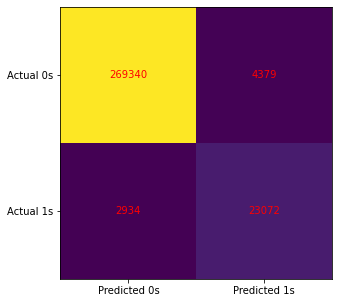

In [40]:
fig , ax = plt.subplots(figsize=(5,5))
ax.imshow(cm_d)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm_d[i,j], ha='center', va='center', color='red')
plt.show()

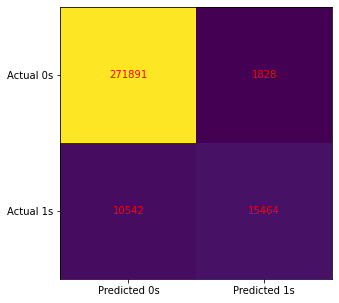

In [41]:
fig , ax = plt.subplots(figsize=(5,5))
ax.imshow(cm_LR)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm_LR[i,j], ha='center', va='center', color='red')
plt.show()

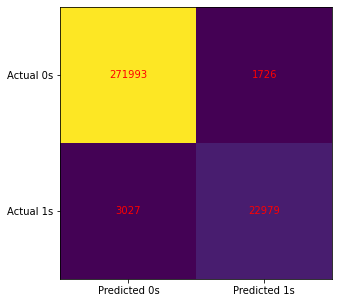

In [42]:
fig , ax = plt.subplots(figsize=(5,5))
ax.imshow(cm_RF)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actual 0s', 'Actual 1s'))
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm_RF[i,j], ha='center', va='center', color='red')
plt.show()